![Logo](assets/logo.png)

Made by **Zoltán Barta**

[<img src="https://colab.research.google.com/assets/colab-badge.svg">](https://colab.research.google.com/github/Fortuz/rl_education/blob/main/Gridworld/Generator/gw_monte_carlo.ipynb)


# Monte Carlo Methods in Gridworld

## Introduction

This notebook explores the application of **Monte Carlo reinforcement learning** techniques in a **Gridworld** environment. Monte Carlo methods estimate value functions and optimize policies through experience-based sampling, making them a powerful tool in reinforcement learning. The implementation leverages Python libraries such as **NumPy, Gymnasium, and Matplotlib** to simulate and analyze agent behavior.


In [1]:
!wget https://raw.githubusercontent.com/Fortuz/rl_education/main/Gridworld/Generator/gridworld.py -O gridworld.py
!wget https://raw.githubusercontent.com/Fortuz/rl_education/main/Gridworld/Generator/FreeMono.ttf -O FreeMono.ttf

zsh:1: command not found: wget
zsh:1: command not found: wget


In [2]:
import time
import numpy as np
from gridworld import Gridworld
import gymnasium as gym
import matplotlib.pyplot as plt
import time
from IPython import display
import pickle

In [3]:

state_types = np.array([
    [0, 0, 0, 1],
    [0, 2, 0, 1],
    [0, 0, 0, 0],
],dtype=int)
shape = state_types.shape



rewards = np.zeros(shape, dtype=int) * -1
rewards[0, 3] = 1
rewards[1, 3] = -1

assert state_types.shape == rewards.shape

# Q-table
q_table = np.zeros(shape + (4,))

# Slip probabilities

slip = {
    'left': 0.0,
    'right': 0.0,
    'backward': 0
}

# Initializing gridworld
gw = Gridworld(state_types, rewards, q_table, gamma=0.9, step_reward=0)

print('State types:')
print(state_types)
print('Rewards:')
print(rewards)

State types:
[[0 0 0 1]
 [0 2 0 1]
 [0 0 0 0]]
Rewards:
[[ 0  0  0  1]
 [ 0  0  0 -1]
 [ 0  0  0  0]]



The `simulate` function runs a single episode in the **Gridworld** environment using a given **policy**. It follows the agent's movement, records the trajectory, accumulates rewards, and stops when a terminal state is reached or a maximum number of steps is taken.


In [4]:
import random


def simulate(gw, policy, max_steps=100):
    """
    Simulates a single episode in the Gridworld environment following the given policy.

    Parameters:
    gw (Gridworld): The Gridworld object.
    policy (np.ndarray): The policy array mapping states to actions.
    max_steps (int): Maximum number of steps before termination.

    Returns:
    trajectory (list): List of (state, action, reward) tuples representing the agent's trajectory.
    total_reward (float): The total reward collected in the episode.
    steps (int): The number of steps taken in the episode.
    """
    # Set starting position as the lower-left corner (bottom row, first column)
    state = (gw.state_types.shape[0] - 1, 0)
    
    # Ensure the starting position is a valid (empty) state
    if gw.state_types[state] != 0:
        raise ValueError("Starting position (lower-left corner) is not a valid empty state.")

    total_reward = 0
    steps = 0
    trajectory = []

    direction_to_offset = {
        0: (-1, 0),  # Up
        1: (0, 1),   # Right
        2: (1, 0),   # Down
        3: (0, -1),  # Left
    }
    
    done = False
    while not done:
 
        action = policy(state)

       
        # Compute next state
        i_off, j_off = direction_to_offset[action]
        next_state = (max(0, min(state[0] + i_off, gw.state_types.shape[0] - 1)),
                      max(0, min(state[1] + j_off, gw.state_types.shape[1] - 1)))

        # If hitting a wall, stay in place
        if gw.state_types[next_state] == 2:
            next_state = state

        # Get reward and update state
        reward = gw.rewards[next_state] + gw.step_reward
        total_reward += reward
        trajectory.append((state, action, reward))  # Store trajectory

        state = next_state
        steps += 1

        # Check if we reached a terminal state
        if gw.state_types[state] == 1:
            done = True

    return trajectory, total_reward, steps


# Epsilon-Greedy Policy for Gridworld

## Overview

The `EpsilonGreedyPolicy` class implements an **epsilon-greedy policy** for a **Gridworld** environment. This policy is commonly used in **reinforcement learning** to balance **exploration** (trying new actions) and **exploitation** (choosing the best-known action).

### How It Works

- With probability **(1 - epsilon)**, the agent selects the action with the highest estimated value (greedy choice).
- With probability **epsilon**, the agent selects a random action to encourage exploration.
- The policy maintains a **state-action value table**, which is updated as the agent learns.

---

## Usage Guide

### 1. **Initializing the Policy**
To create an epsilon-greedy policy, define the shape of the Gridworld and the exploration parameter (`epsilon`):

```python
from epsilon_greedy_policy import EpsilonGreedyPolicy

# Define grid size (e.g., 3x4 gridworld)
grid_shape = (3, 4)

# Initialize policy with 4 possible actions (Up, Right, Down, Left) and epsilon=0.1
policy = EpsilonGreedyPolicy(shape=grid_shape, num_actions=4, epsilon=0.1)

In [5]:
import numpy as np

class EpsilonGreedyPolicy:
    """
    An epsilon-greedy policy for the Gridworld environment.

    This policy selects the action with the highest estimated value most of the time 
    (1 - epsilon probability), while occasionally choosing a random action (epsilon probability) 
    to encourage exploration.
    """

    def __init__(self, shape, num_actions=4, epsilon=0.1):
        """
        Initializes the epsilon-greedy policy.

        Parameters:
        ----------
        shape : tuple
            The shape of the environment grid (rows, cols).
        num_actions : int, optional
            The number of possible actions (default is 4: Up, Right, Down, Left).
        epsilon : float, optional
            The probability of selecting a random action instead of the greedy action (default is 0.1).
        """
        self.shape = shape
        self.num_actions = num_actions
        self.epsilon = epsilon
        self.policy = {(x, y): [0.0 for _ in range(num_actions)] for x in range(shape[0]) for y in range(shape[1])}

    def argmax(self, actions):
        """
        Returns the index of the action with the highest estimated value.

        If multiple actions have the same highest value, one is selected randomly.

        Parameters:
        ----------
        actions : list
            A list of action values.

        Returns:
        -------
        int
            The index of the action with the highest estimated value.
        """
        max_a = max(actions)
        return np.random.choice([i for i, a in enumerate(actions) if a == max_a])

    def __call__(self, state):
        """
        Selects an action for the given state using the epsilon-soft strategy.
        
        Every action has at least ε/num_actions probability of being chosen.
        """
        probabilities = np.ones(self.num_actions) * (self.epsilon / self.num_actions)
        best_action = self.argmax(self.policy[state])
        probabilities[best_action] += (1 - self.epsilon)
    
        return np.random.choice(self.num_actions, p=probabilities)

    def update_policy(self, state, action, value):
        """
        Updates the estimated value of a specific action in a given state.

        Parameters:
        ----------
        state : tuple
            The (row, col) position in the grid.
        action : int
            The action index (0=Up, 1=Right, 2=Down, 3=Left).
        value : float
            The new estimated value for the given state-action pair.
        """
        self.policy[state][action] = value

    def get_state_action_value(self, state, action):
        """
        Retrieves the estimated value of a specific state-action pair.

        Parameters:
        ----------
        state : tuple
            The (row, col) position in the grid.
        action : int
            The action index.

        Returns:
        -------
        float
            The estimated value of taking the given action in the given state.
        """
        return self.policy[state][action]


    def get_greedy_policy(self):
        """
        Extracts the greedy policy from the current estimated values.

        The greedy policy selects the action with the highest estimated value in each state.

        Returns:
        -------
        np.ndarray
            A 2D array where each element represents the best action for that state.
        """
        greedy_policy = np.zeros(self.shape, dtype=int)
        for state in self.policy:
            greedy_policy[state] = self.argmax(self.policy[state])
        return greedy_policy


In [6]:

policy = EpsilonGreedyPolicy(shape, epsilon=0.1)
trajectory, total_reward, steps = simulate(gw, policy,max_steps=1000)

print(f"Total reward: {total_reward}, Steps taken: {steps}")
print("Trajectory:")
for t in trajectory:
    print(f"State: {t[0]}, Action: {t[1]}, Reward: {t[2]}")

Total reward: 1, Steps taken: 14
Trajectory:
State: (2, 0), Action: 0, Reward: 0
State: (1, 0), Action: 0, Reward: 0
State: (0, 0), Action: 3, Reward: 0
State: (0, 0), Action: 1, Reward: 0
State: (0, 1), Action: 0, Reward: 0
State: (0, 1), Action: 1, Reward: 0
State: (0, 2), Action: 2, Reward: 0
State: (1, 2), Action: 3, Reward: 0
State: (1, 2), Action: 3, Reward: 0
State: (1, 2), Action: 2, Reward: 0
State: (2, 2), Action: 0, Reward: 0
State: (1, 2), Action: 3, Reward: 0
State: (1, 2), Action: 0, Reward: 0
State: (0, 2), Action: 1, Reward: 1


![MC](assets/OPMCFV.png)

In [7]:
import numpy as np
from collections import defaultdict

def monte_carlo_first_visit(gw, policy, num_episodes=100, gamma=0.9):
    """
    Monte Carlo First-Visit Control using an epsilon-greedy policy.
    
    Parameters:
    gw (Gridworld): The Gridworld object.
    policy (EpsilonGreedyPolicy): The epsilon-greedy policy object.
    num_episodes (int): Number of episodes to run.
    gamma (float): Discount factor for future rewards.
    
    Returns:
    Q (dict): State-action value function.
    policy (EpsilonGreedyPolicy): Updated policy after learning.
    """
    # Initialize Q-value function and returns tracking
    Q = defaultdict(lambda: [0.0] * policy.num_actions)
    returns = defaultdict(list)  # Stores returns for each (state, action) pair
    steps_counts = []
    rewards = []
    for episode in range(num_episodes):
        trajectory, total_reward, steps = simulate(gw, policy)  # Generate an episode
        steps_counts.append(steps)
        rewards.append(total_reward)
        G = 0  # Initialize return
        visited = set()  # Track first visits
        
        # Reverse iterate through the episode to calculate returns
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = gamma * G + reward  # Discounted return
            
            if (state, action) not in visited:  # First-visit check
                visited.add((state, action))
                returns[(state, action)].append(G)
                
                # Update Q-value function
                Q[state][action] = np.mean(returns[(state, action)])  # Average returns
                
                # Policy improvement: Choose best action with epsilon-greedy
                policy.update_policy(state, np.argmax(Q[state]), np.max(Q[state]))
    
        if episode % 100 == 0:
            print(f"Episode {episode}/{num_episodes} complete.")

    return Q, policy,steps_counts,rewards

In [8]:
policy = EpsilonGreedyPolicy(shape, epsilon=0.1)
Q, updated_policy,steps_counts,rewards = monte_carlo_first_visit(gw, policy, num_episodes=1000)

Episode 0/1000 complete.
Episode 100/1000 complete.
Episode 200/1000 complete.
Episode 300/1000 complete.
Episode 400/1000 complete.
Episode 500/1000 complete.
Episode 600/1000 complete.
Episode 700/1000 complete.
Episode 800/1000 complete.
Episode 900/1000 complete.


In [9]:

def plot_moving_average(data, window_size):
    """
    Plots the moving average of a given list of numbers.

    Parameters:
    - data (list or array): The numerical data.
    - window_size (int): The window size for the moving average.

    Returns:
    - A plot displaying the original data and moving average.
    """


    # Compute moving average
    moving_avg = np.convolve(data, np.ones(window_size)/window_size, mode='valid')

    # Plot
    plt.figure(figsize=(10, 5))
    plt.plot(data, label="Original Data", linestyle='-', alpha=0.6)
    plt.plot(range(window_size - 1, len(data)), moving_avg, label=f"{window_size}-point Moving Average", color='red', linewidth=2)
    
    plt.xlabel("Index")
    plt.ylabel("Value")
    plt.title(f"Moving Average (Window Size: {window_size})")
    plt.legend()
    plt.grid(True)
    plt.show()

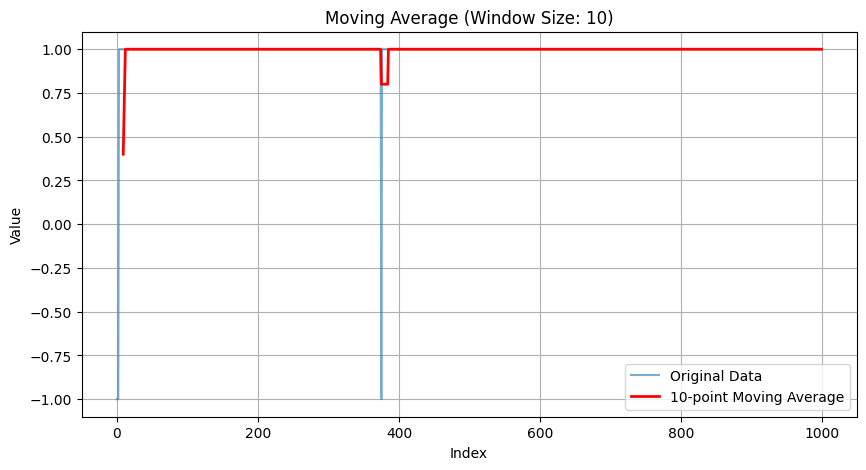

In [10]:
plot_moving_average(rewards, window_size=10)

In [11]:
final_p = policy.get_greedy_policy()

In [12]:
import numpy as np

def q_dict_to_array(q_dict, shape):
    """
    Converts a Q-value dictionary into a NumPy array.

    Parameters:
    q_dict (dict): Dictionary mapping (state) -> [Q-values for actions].
    shape (tuple): Shape of the environment grid (height, width).

    Returns:
    np.ndarray: NumPy array of shape (height, width, num_actions).
    """
    height, width = shape
    num_actions = 4  # Assuming 4 actions (Up, Right, Down, Left)

    # Initialize Q-table with zeros
    q_array = np.zeros((height, width, num_actions))

    # Populate array with dictionary values
    for (i, j), q_values in q_dict.items():
        q_array[i, j, :] = q_values  # Assign Q-values to the respective state

    return q_array

In [13]:
q_table = q_dict_to_array(policy.policy, shape)

In [14]:
final_p = policy.get_greedy_policy()

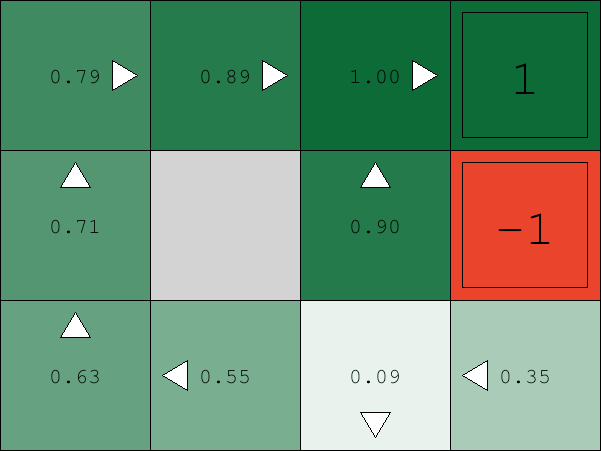

In [15]:
gw.render(q_table,policy=True)

Episode 0/1000 complete.
Episode 100/1000 complete.
Episode 200/1000 complete.
Episode 300/1000 complete.
Episode 400/1000 complete.
Episode 500/1000 complete.
Episode 600/1000 complete.
Episode 700/1000 complete.
Episode 800/1000 complete.
Episode 900/1000 complete.


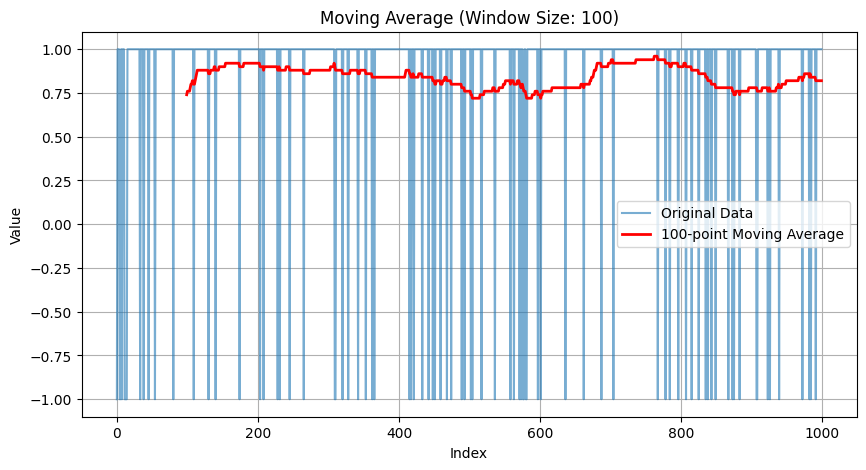

In [16]:
policy = EpsilonGreedyPolicy(shape, epsilon=0.6)
Q, updated_policy,steps_counts,rewards = monte_carlo_first_visit(gw, policy, num_episodes=1000)
plot_moving_average(rewards, window_size=100)